In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters

In [68]:
# 17665

In [69]:
company_id = 17665
date_min = ''
date_max = ''

In [70]:
# Default value for date_min and max
date_min = '2019-01-01' if (date_min == '') else date_min
date_max = '2021-12-31' if (date_max == '') else date_max

# Auxiliar

In [71]:
import os
import pymysql


def get_data_sql(query):
    """Acquire a dataset from a sql query either from prod or dev database.

    For security purposes, some of the parameters for the connection are
    environment variables and should be set when configuring the conda env.
    For more information, check the README.expor
    """

  
    connection = pymysql.connect(user=os.environ['DB_USER'],
                                 password=os.environ['DB_PASS'],
                                 host=os.environ['DB_HOST'],
                                 port=int(os.environ['DB_PORT']),
                                 db=os.environ['DB_NAME'],
                                 charset='utf8mb4',
                                 cursorclass=pymysql.cursors.DictCursor)
    data = pd.read_sql(query, connection)
    return data

In [72]:
def plot_heatmap1(values, title='', figsize=(10, 5), **kwargs):
    """To keep a pattern in the notebook."""
    plt.figure(figsize=figsize)
    sns.heatmap(values, linewidths=0, linecolor='red',cmap='binary',  vmin=0, vmax=1, **kwargs)
    plt.title(title)
    plt.show()

In [73]:
def plot_heatmap(values, title='', figsize=(10, 5), **kwargs):
    """To keep a pattern in the notebook."""
    plt.figure(figsize=figsize)
    plt.imshow(values, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()


In [74]:
def check_null(data): 
    """Print quantity of null values of whole dataset."""
    
    raw = data.isnull().sum()
    percent = data.isnull().sum()/data.shape[0]

    values = []
    for i, x in enumerate(raw.values):
        values.append('{} ({:.5f}%)'.format(x, percent[i]))

    null = pd.Series(index=raw.keys(), data=values)
    
    return null

<br>

<h1 align='center'>Parcing Analysis</h1>

## Queries

In [75]:
query_rating = """
SELECT
        a.id,
        a.resume_id AS resume_id,
        a.application_date,
        ar.id AS acquired_resume_id,
        jg.product_id,
        ar.application_job_title,
        jg.full_name AS job_group_name,
        jg.company_id AS job_group_company_id,
        p.rating,
        p.rating_original,
        COUNT(CASE WHEN parsed_job=0 THEN 1 END) as count_not_parsed_job,
        COUNT(CASE WHEN parsed_job=1 THEN 1 END) as count_august_parsed_job,
        COUNT(CASE WHEN parsed_job=2 THEN 1 END) as count_august_not_parsed_job,
        COUNT(CASE WHEN parsed_job=3 THEN 1 END) as count_human_check_parsed_job,
        COUNT(CASE WHEN parsed_company=0 THEN 1 END) as count_not_parsed_company,
        COUNT(CASE WHEN parsed_company=1 THEN 1 END) as count_august_parsed_company,
        COUNT(CASE WHEN parsed_company=2 THEN 1 END) as count_august_not_parsed_company,
        COUNT(CASE WHEN parsed_company=3 THEN 1 END) as count_human_parsed_company
    FROM acquired_resume ar
        LEFT JOIN acquired_work AS aw ON ar.id=aw.acquired_resume_id
        LEFT JOIN work AS w ON w.acquired_work_id=aw.id
        LEFT JOIN resume AS r ON r.acquired_resume_id = ar.id
        LEFT JOIN application AS a ON a.resume_id = r.id
        LEFT JOIN prediction_hiring AS p ON p.application_id = a.id
        LEFT JOIN requisition AS rq ON a.requisition_id = rq.id
        LEFT JOIN job_title AS jt ON jt.id = rq.job_title_id
        LEFT JOIN job_group AS jg ON jg.id = jt.job_group_id
    WHERE jg.company_id = {COMPANY_ID}
        AND a.application_date BETWEEN '{DATE_MIN}' AND '{DATE_MAX}'
    GROUP BY resume_id,a.application_date,job_group_name;
""".format(COMPANY_ID=company_id,DATE_MIN=date_min,DATE_MAX=date_max)

## Environ
%env DB_NAME=
%env DB_HOST=
%env DB_PASS=
%env DB_USER=
%env DB_PORT=

## > Get data

In [76]:
#df = get_data_sql(query_rating)
df = pd.read_csv('hiring_ratings1.csv')

In [77]:
df = df.drop_duplicates()

In [78]:
print('There are {} unique IDs with ratings in the specified period.'.format(df['resume_id'].nunique()))
print("There are {} rows with ratings in the specified period.".format(df.shape[0]))

There are 328 unique IDs with ratings in the specified period.
There are 328 rows with ratings in the specified period.


## > Check Null

In [79]:
check_null(df)

id                                   0 (0.00000%)
resume_id                            0 (0.00000%)
application_date                     0 (0.00000%)
acquired_resume_id                   0 (0.00000%)
product_id                           0 (0.00000%)
application_job_title              145 (0.44207%)
job_group_name                       0 (0.00000%)
job_group_company_id                 0 (0.00000%)
rating                             318 (0.96951%)
rating_original                    328 (1.00000%)
count_not_parsed_job                 0 (0.00000%)
count_august_parsed_job              0 (0.00000%)
count_august_not_parsed_job          0 (0.00000%)
count_human_check_parsed_job         0 (0.00000%)
count_not_parsed_company             0 (0.00000%)
count_august_parsed_company          0 (0.00000%)
count_august_not_parsed_company      0 (0.00000%)
count_human_parsed_company           0 (0.00000%)
dtype: object

## > Distribution

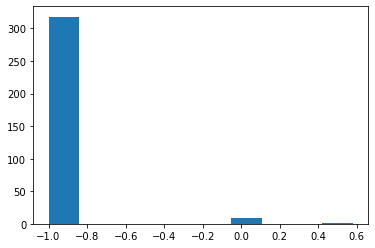

In [80]:
plt.hist(df['rating'].fillna(-1))
plt.show()

## > Functions

In [81]:
def count_job_title_parseds(df):
    not_parsed = df['count_not_parsed_job'].sum()
    august_parsed = df['count_august_parsed_job'].sum()
    august_not_parsed = df['count_august_not_parsed_job'].sum()
    human_checked = df['count_human_check_parsed_job'].sum()
    parsed_mean = august_parsed / df['resume_id'].nunique()
    max_parsed = df['count_august_parsed_job'].max()
    min_parsed = df['count_august_parsed_job'].min()
    print('AUGUST JOB TITLES\n')
    print('Not Parsed: '+str(not_parsed)+'('+str(round(not_parsed/df.shape[0],4))+'%)')
    print('August Parsed: '+str(august_parsed)+'('+str(round(august_parsed/df.shape[0],4))+'%)')
    print('August Not Parsed: '+str(august_not_parsed)+'('+str(round(august_not_parsed/df.shape[0],4))+'%)')
    print('Human Checked: '+str(human_checked)+'('+str(round(human_checked/df.shape[0],4))+'%)')
    print('Mean Parsed Job Titles a Candidate: '+str(round(parsed_mean,4)))
    print('Min Parsed Job Titles a Candidate: '+str(round(min_parsed,4)))
    print('Max Parsed Job Titles a Candidate: '+str(round(max_parsed,4)))

def count_company_parseds(df):
    not_parsed = df['count_not_parsed_company'].sum()
    august_parsed = df['count_august_parsed_company'].sum()
    august_not_parsed = df['count_august_not_parsed_company'].sum()
    human_checked = df['count_human_parsed_company'].sum()
    parsed_mean = august_parsed / df['resume_id'].nunique()
    max_parsed = df['count_august_parsed_company'].max()
    min_parsed = df['count_august_parsed_company'].min()
    print('AUGUST COMPANIES\n')
    print('Not Parsed: '+str(not_parsed)+'('+str(round(not_parsed/df.shape[0],4))+'%)')
    print('August Parsed: '+str(august_parsed)+'('+str(round(august_parsed/df.shape[0],4))+'%)')
    print('August Not Parsed: '+str(august_not_parsed)+'('+str(round(august_not_parsed/df.shape[0],4))+'%)')
    print('Human Checked: '+str(human_checked)+'('+str(round(human_checked/df.shape[0],4))+'%)')
    print('Mean Parsed Companies a Candidate: '+str(round(parsed_mean,4)))
    print('Min Parsed Companies a Candidate: '+str(round(min_parsed,4)))
    print('Max Parsed Companies a Candidate: '+str(round(max_parsed,4)))

def explore_experience(df):
    #columns_to_print = ['aw_job_title','aw_company','date_start','date_end']
    list_ids_job_title_null = []
    list_ids_date_start_null = []
    list_ids_august_parsed_job_null = []
    list_ids_application_job_title_null = []
    list_ids_date_start_bigger_date_end = []
    list_ids_atention = []
    df.reset_index(inplace = True)
    df.set_index('resume_id',inplace = True)
    for i in df.index.unique():
        temp = df.loc[i]
        print_space = False
        if isinstance(temp,pd.Series):
            temp = pd.DataFrame(temp).T
        #Checking JobTitle
        feature = 'aw_job_title'
        if temp[temp[feature].notna()].shape[0]==0:
            list_ids_job_title_null.append(i)
            print_space = True
        #Checking Date_start
        feature = 'date_start'
        if temp[temp[feature].notna()].shape[0]==0:
            list_ids_date_start_null.append(i)
            print_space = True
        #Checking August_parsed_job
        feature = 'august_parsed_job'
        if temp[temp[feature]==1].shape[0]==0:
            list_ids_august_parsed_job_null.append(i)
            print_space = True
        #Checking application_job_title
        feature = 'application_job_title'
        if temp[temp[feature]!='null'].shape[0]==0:
            list_ids_application_job_title_null.append(i)
            print_space = True
        #Checking date_start > date_end
        if temp[temp['date_start']>temp['date_end']].shape[0]!=0:
            list_ids_date_start_bigger_date_end.append(i)
            print_space = True    
        if not print_space:
                list_ids_atention.append(i)
    print('IDs WITH PROBLEMS')
    print('Date Start null: '+str(len(list_ids_date_start_null)))
    print('Job Title null: '+str(len(list_ids_job_title_null)))
    print('August Parsed Jobs null: '+str(len(list_ids_august_parsed_job_null)))
    print('Application Job Title null: '+str(len(list_ids_application_job_title_null)))
    print('Date Start is Bigger than Date End: '+str(len(list_ids_date_start_bigger_date_end)))
    print('WARNING, problems did not find: '+str(len(list_ids_atention)))
    print('Details')
    #print(df.loc[list_ids_atention].index.values[1]+df.loc[list_ids_atention]['date_start']+'|'+df.loc[list_ids_atention]['aw_job_title']
    #      +'|'+df.loc[list_ids_atention]['aw_company']+'|'+df.loc[list_ids_atention]['w_onetsoc_code']
    #      +'|'+df.loc[list_ids_atention]['august_parsed_company']+'|'+df.loc[list_ids_atention]['august_parsed_job'])
    for j in list_ids_atention:
        temp = df.loc[j].reset_index()
        print('>> ID: {}'.format(j))
        for k in range(0,len(temp)):
            print('Date Start: {} | Job Title: {} | Company {} | Onetsoc Code: {} | Parsed Company: {} | Parsed Job Title: {}.'.format(
                temp.loc[k,'date_start'],temp.loc[k,'aw_job_title'],temp.loc[k,'aw_company'],temp.loc[k,'w_onetsoc_code'],
                temp.loc[k,'august_parsed_company'],temp.loc[k,'august_parsed_job']))
        print('\n')

## > Job Title Statistics

In [82]:
count_job_title_parseds(df)

AUGUST JOB TITLES

Not Parsed: 409(1.247%)
August Parsed: 54(0.1646%)
August Not Parsed: 14(0.0427%)
Human Checked: 0(0.0%)
Mean Parsed Job Titles a Candidate: 0.1646
Min Parsed Job Titles a Candidate: 0
Max Parsed Job Titles a Candidate: 5


## > Company Statistics

In [83]:
count_company_parseds(df)

AUGUST COMPANIES

Not Parsed: 409(1.247%)
August Parsed: 30(0.0915%)
August Not Parsed: 38(0.1159%)
Human Checked: 0(0.0%)
Mean Parsed Companies a Candidate: 0.0915
Min Parsed Companies a Candidate: 0
Max Parsed Companies a Candidate: 3


<br>

<h1 align='center'>Get Experience of candidates with Rating 0.0 or Null</h1>

In [84]:
#Filting the ids that have rating null or Zero
ids_rating_zero = tuple(df.loc[(df['rating']==0) | (df['rating'].isna())]['id'].values)

## > Queries

In [85]:
query_experience = """
SELECT
        a.resume_id AS resume_id,
        a.application_date,
        ar.id AS acquired_resume_id,
        jg.product_id,
        ar.application_job_title,
        jg.full_name AS job_group_name,
        jg.company_id AS job_group_company_id,
        p.rating,
        p.rating_original,
        aw.date_start AS date_start,
        aw.date_end AS date_end,
        aw.job_title AS aw_job_title,
        w.occupation_data_onetsoc_code AS w_onetsoc_code,
        aw.company AS aw_company,
        w.company_id AS w_company_id,
        parsed_company AS august_parsed_company,
        parsed_job AS august_parsed_job
    FROM acquired_resume ar
        LEFT JOIN acquired_work AS aw ON ar.id=aw.acquired_resume_id
        LEFT JOIN work AS w ON w.acquired_work_id=aw.id
        LEFT JOIN resume AS r ON r.acquired_resume_id = ar.id
        LEFT JOIN application AS a ON a.resume_id = r.id
        LEFT JOIN prediction_hiring AS p ON p.application_id = a.id
        LEFT JOIN requisition AS rq ON a.requisition_id = rq.id
        LEFT JOIN job_title AS jt ON jt.id = rq.job_title_id
        LEFT JOIN job_group AS jg ON jg.id = jt.job_group_id
    WHERE jg.company_id = {COMPANY_ID}
        AND a.application_date BETWEEN '{DATE_MIN}' AND '{DATE_MAX}'
        AND a.id IN
            {IDS_RATING_ZERO};
""".format(COMPANY_ID=company_id,IDS_RATING_ZERO=ids_rating_zero,DATE_MIN=date_min,DATE_MAX=date_max)

## > Get data

In [97]:
#df_experience = get_data_sql(query_experience)
df_experience = pd.read_csv('riring_ratings.csv')

FileNotFoundError: [Errno 2] File riring_ratings.csv does not exist: 'riring_ratings.csv'

In [98]:
df_experience = df_experience.drop_duplicates()

In [99]:
print('There are {} unique IDs unique IDs with ratings in the specified period.'.format(df_experience['resume_id'].nunique()))
print("There are {} rows with ratings in the specified period.".format(df_experience.shape[0]))

There are 328 unique IDs unique IDs with ratings in the specified period.
There are 328 rows with ratings in the specified period.


## > Split rows with rating 0.0 and Null

In [100]:
zero_rating = df_experience.loc[df_experience['rating']==0].set_index('resume_id')

In [101]:
null_rating = df_experience.loc[df_experience['rating'].isna()].set_index('resume_id')

<br>

<h2 align='center'>Checking Experiences that rating rows is Null</h2>

### > Check for invalid dates

In [102]:
date_cols = ['date_end', 'date_start']

if null_rating.shape[0]:
    for col in date_cols:
        null_rating['year_' + col] = null_rating[col].fillna(np.nan).astype(str).str.split('-', expand=True)[0].astype(float)  # get year

    year_cols = ['year_' + col for col in date_cols]
    g2020 = null_rating[year_cols]>2020
    g2020.columns = [col + '>2020' for col in year_cols]
    l1970 = null_rating[year_cols]<1970
    l1970.columns = [col + '<1970' for col in year_cols]
    
    date_conditionals = pd.concat([g2020, l1970], axis=1)


KeyError: 'date_end'

### > Check for invalid experiences

In [103]:
invalid_xp_cols = ['date_start', 'date_end', 'aw_job_title', 'w_onetsoc_code', 'aw_company', 'w_company_id']

null_count = []
for col in invalid_xp_cols:
    null_count.append(null_rating[col].isna().sum())

KeyError: 'date_start'

ValueError: shape mismatch: objects cannot be broadcast to a single shape

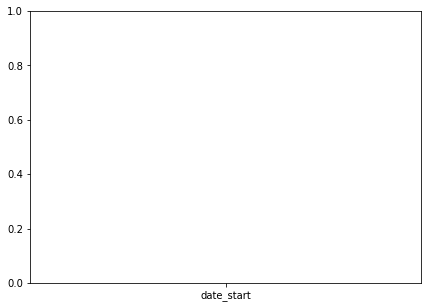

In [104]:
plt.figure(figsize=(7, 5))
plt.bar(invalid_xp_cols, null_count, 0.5)
plt.title('Count of null rows by column')
plt.xticks(rotation=90)
plt.show()
print(null_count)

### > Check Null

In [105]:
check_null(null_rating)

id                                   0 (0.00000%)
application_date                     0 (0.00000%)
acquired_resume_id                   0 (0.00000%)
product_id                           0 (0.00000%)
application_job_title              144 (0.45283%)
job_group_name                       0 (0.00000%)
job_group_company_id                 0 (0.00000%)
rating                             318 (1.00000%)
rating_original                    318 (1.00000%)
count_not_parsed_job                 0 (0.00000%)
count_august_parsed_job              0 (0.00000%)
count_august_not_parsed_job          0 (0.00000%)
count_human_check_parsed_job         0 (0.00000%)
count_not_parsed_company             0 (0.00000%)
count_august_parsed_company          0 (0.00000%)
count_august_not_parsed_company      0 (0.00000%)
count_human_parsed_company           0 (0.00000%)
dtype: object

### > Plot null rows

In [106]:
plot_heatmap(null_rating[invalid_xp_cols].isna(), title='Heatmap of Null columns')
print(null_rating[invalid_xp_cols].isna().sum())

KeyError: "None of [Index(['date_start', 'date_end', 'aw_job_title', 'w_onetsoc_code',\n       'aw_company', 'w_company_id'],\n      dtype='object')] are in the [columns]"

### > Check dates range

In [107]:
plot_heatmap(date_conditionals, title='Heatmap of dates out of range', figsize=(15, 8))
print(date_conditionals.sum())

NameError: name 'date_conditionals' is not defined

### > Analysing Experience Details

In [108]:
explore_experience(null_rating)

KeyError: 'aw_job_title'

<br>

<h2 align='center'>Checking Experiences that rating rows is 0.0</h2>

### > Check for invalid dates

In [109]:
date_cols = ['date_end', 'date_start']

if zero_rating.shape[0]:
    for col in date_cols:
        zero_rating['year_' + col] = zero_rating[col].fillna(np.nan).astype(str).str.split('-', expand=True)[0].astype(float)  # get year

    year_cols = ['year_' + col for col in date_cols]
    g2020 = zero_rating[year_cols]>2020
    g2020.columns = [col + '>2020' for col in year_cols]
    l1970 = zero_rating[year_cols]<1970
    l1970.columns = [col + '<1970' for col in year_cols]

    date_conditionals = pd.concat([g2020, l1970], axis=1)

KeyError: 'date_end'

### > Check for invalid experiences

In [110]:
invalid_xp_cols = ['date_start', 'date_end', 'aw_job_title', 'w_onetsoc_code', 'aw_company', 'w_company_id']

null_count = []
for col in invalid_xp_cols:
    null_count.append(zero_rating[col].isna().sum())

KeyError: 'date_start'

ValueError: shape mismatch: objects cannot be broadcast to a single shape

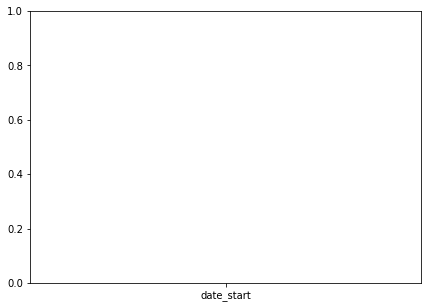

In [111]:
plt.figure(figsize=(7, 5))
plt.bar(invalid_xp_cols, null_count, 0.5)
plt.title('Count of null rows by column')
plt.xticks(rotation=90)
plt.show()
print(null_count)

### > Check Null

In [112]:
check_null(zero_rating)

id                                 0 (0.00000%)
application_date                   0 (0.00000%)
acquired_resume_id                 0 (0.00000%)
product_id                         0 (0.00000%)
application_job_title              1 (0.11111%)
job_group_name                     0 (0.00000%)
job_group_company_id               0 (0.00000%)
rating                             0 (0.00000%)
rating_original                    9 (1.00000%)
count_not_parsed_job               0 (0.00000%)
count_august_parsed_job            0 (0.00000%)
count_august_not_parsed_job        0 (0.00000%)
count_human_check_parsed_job       0 (0.00000%)
count_not_parsed_company           0 (0.00000%)
count_august_parsed_company        0 (0.00000%)
count_august_not_parsed_company    0 (0.00000%)
count_human_parsed_company         0 (0.00000%)
dtype: object

### > Plot null rows

In [113]:
plot_heatmap(zero_rating[invalid_xp_cols].isna(), title='Heatmap of Null columns')
print(zero_rating[invalid_xp_cols].isna().sum())

KeyError: "None of [Index(['date_start', 'date_end', 'aw_job_title', 'w_onetsoc_code',\n       'aw_company', 'w_company_id'],\n      dtype='object')] are in the [columns]"

### > Check dates range

In [114]:
plot_heatmap(date_conditionals, title='Heatmap of dates out of range', figsize=(15, 8))
print(date_conditionals.sum())

NameError: name 'date_conditionals' is not defined

### > Analysing Experience Details

In [115]:
explore_experience(zero_rating)

KeyError: 'aw_job_title'